# Generate compartmentalization results

This notebook generates the results for panel d: It stimulates the cell locally and records voltage and calcium.

This notebook also computes the receptive fields for panel e, using the data generated with the notebook `03_evaluate.ipynb`.

Michael Deistler ran this notebook on a Macbook Pro.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [3]:
import time

import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib as mpl
import h5py
from functools import partial
import jax
import jaxlib

import jaxley as jx

from nex.rgc.utils.data_utils import (
    read_data,
    build_avg_recordings,
    build_training_data,
)
from nex.rgc.utils.utils import (
    build_cell,
    build_kernel,
)
from nex.rgc.utils.rf_utils import compute_all_trained_rfs
from nex.rgc.simulate import (
    predict,
    simulate,
)

In [4]:
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [5]:
print(f"jax {jax.__version__}")
print(f"jaxlib {jaxlib.__version__}")
print(f"pandas {pd.__version__}")
print(f"numpy {np.__version__}")

jax 0.4.29
jaxlib 0.4.28
pandas 2.2.1
numpy 1.26.4


In [6]:
path_prefix = "../../../nex/rgc"
results_prefix = "results/train_runs/2024_08_01__20_57_21/0"

In [7]:
start_n_scan = 0
num_datapoints_per_scanfield = 128 * 8
nseg = 4
cell_id = "20161028_1"
rec_ids = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

In [8]:
stimuli, recordings, setup, noise_full = read_data(
    start_n_scan,
    num_datapoints_per_scanfield,
    cell_id,
    rec_ids,
    "noise",
    ".."
)

# avg_recordings = build_avg_recordings(
#     recordings, rec_ids, nseg, num_datapoints_per_scanfield
# )
# with open("../results/intermediate/avg_recordings.pkl", "wb") as handle:
#     pickle.dump(avg_recordings, handle)
with open(f"{path_prefix}/results/intermediate/avg_recordings.pkl", "rb") as handle:
    avg_recordings = pickle.load(handle)

number_of_recordings_each_scanfield = list(avg_recordings.groupby("rec_id").size())

In [9]:
warmup = 5.0
i_amp = 0.1

currents, labels, loss_weights = build_training_data(
    i_amp,
    stimuli,
    avg_recordings,
    rec_ids, 
    num_datapoints_per_scanfield,
    number_of_recordings_each_scanfield,
)

stim_branch_inds = stimuli["branch_ind"].to_numpy()
stim_comps = stimuli["comp"].to_numpy()

In [10]:
dt = 0.025
t_max = 200.0
time_vec = np.arange(0, t_max+2*dt, dt)

In [11]:
with open(f"{path_prefix}/{results_prefix}/cell.pkl", "rb") as handle:
    cell = pickle.load(handle)

basal_inds = list(np.unique(cell.group_nodes["basal"]["branch_index"].to_numpy()))
somatic_inds = list(np.unique(cell.group_nodes["soma"]["branch_index"].to_numpy()))

cell.delete_recordings()
cell.delete_stimuli()

for i, rec in avg_recordings.iterrows():
    cell.branch(rec["branch_ind"]).loc(rec["comp"]).record("Cai", verbose=False)

for i, rec in avg_recordings.iterrows():
    cell.branch(rec["branch_ind"]).loc(rec["comp"]).record("v", verbose=False)

print(f"Inserted {len(cell.recordings)} recordings")
print(f"number_of_recordings_each_scanfield {number_of_recordings_each_scanfield}")
number_of_recordings = np.sum(number_of_recordings_each_scanfield)

Inserted 294 recordings
number_of_recordings_each_scanfield [12, 6, 15, 21, 13, 10, 9, 10, 10, 6, 4, 11, 8, 4, 8]


In [12]:
_, init_states = jx.integrate(cell, t_max=warmup, return_states=True)

In [13]:
cell.delete_trainables()
cell.basal.branch("all").make_trainable("axial_resistivity")
cell.basal.branch("all").make_trainable("radius")

Number of newly added trainable parameters: 154. Total number of trainable parameters: 154
Number of newly added trainable parameters: 154. Total number of trainable parameters: 308


In [14]:
kernel = build_kernel(time_vec, dt)
output_scale = jnp.asarray(60.0)
output_offset = jnp.asarray(-1.3)

In [15]:
with open(f"{path_prefix}/{results_prefix}/opt_params/params_16.pkl", "rb") as handle:
    all_opt_params = pickle.load(handle)

with open(f"{path_prefix}/{results_prefix}/transforms/transform_params.pkl", "rb") as handle:
    transform_params = pickle.load(handle)

with open(f"{path_prefix}/{results_prefix}/transforms/transform_basal.pkl", "rb") as handle:
    transform_basal = pickle.load(handle)

with open(f"{path_prefix}/{results_prefix}/transforms/transform_somatic.pkl", "rb") as handle:
    transform_somatic = pickle.load(handle)

opt_params, opt_basal_params, opt_somatic_params = all_opt_params

parameters = transform_params.forward(opt_params)
basal_neuron_params = transform_basal.forward(opt_basal_params)
somatic_neuron_params = transform_somatic.forward(opt_somatic_params)

In [16]:
num_truncations = 4

static = {
    "cell": cell,
    "dt": dt,
    "t_max": t_max,
    "time_vec": time_vec,
    "num_truncations": num_truncations,
    "output_scale": output_scale,
    "output_offset": output_offset,
    "kernel": kernel,
    "somatic_inds": somatic_inds,
    "basal_inds": basal_inds,
    "stim_branch_inds": stim_branch_inds,
    "stim_comps": stim_comps,
}
vmapped_predict = jit(vmap(partial(predict, static=static), in_axes=(None, None, None, 0, None)))

### Panel d: Compartmentalized computation

In [17]:
cell.delete_recordings()
cell.delete_stimuli()

for b in range(155):
    cell.branch(b).comp(1).record("Cai", verbose=False)
for b in range(155):
    cell.branch(b).comp(1).record("v", verbose=False)


from nex.rgc.simulate import predict, simulate
vmapped_sim = jit(vmap(partial(simulate, static=static), in_axes=(None, None, None, 0, None)))


def convolution(v):
    """Return calcium activity in each of the recordings."""
    v = v[:, :len(kernel)]
    convolved_at_last_time = jnp.mean(jnp.flip(kernel) * v, axis=1)
    return convolved_at_last_time

vmapped_convolution = jit(vmap(convolution, in_axes=(0)))


In [18]:
inds = np.arange(0, 140, 5)[[3, 21]].tolist()  # 21 is good  # 3 is ok

stim_branches_save = [stim_branch_inds[ind] for ind in inds]
stim_comp_save = [stim_comps[ind] for ind in inds]

with open(f"../results/03_results/compartemtalization_stim_branches.pkl", "wb") as handle:
    pickle.dump(stim_branches_save, handle)

with open(f"../results/03_results/compartemtalization_stim_comps.pkl", "wb") as handle:
    pickle.dump(stim_comp_save, handle)

for i, ind in enumerate(inds):
    dummy = np.zeros((1, 287))
    dummy[:, ind] = 0.015
    dummy = jnp.asarray(dummy)
    
    v_trained = vmapped_sim(
        transform_params.forward(opt_params), 
        transform_basal.forward(opt_basal_params),
        transform_somatic.forward(opt_somatic_params),
        dummy,
        init_states,
    )
    ca = vmapped_convolution(v_trained)

    with open(f"../results/03_results/compartemtalization_v_{i}.pkl", "wb") as handle:
        pickle.dump(v_trained, handle)

    with open(f"../results/03_results/compartemtalization_ca_{i}.pkl", "wb") as handle:
        pickle.dump(ca, handle)

In [19]:
with open(f"../results/03_results/compartemtalization_stim_branches.pkl", "rb") as handle:
    stim_branches_save = pickle.load(handle)

with open(f"../results/03_results/compartemtalization_stim_comps.pkl", "rb") as handle:
    stim_comps_save = pickle.load(handle)

In [20]:
stim_branches_save

[28, 142]

/var/folders/kv/39t9blx569l5_sxxzx89vb3c0000gn/T/ipykernel_88723/1145316525.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis')


i 0
b 28


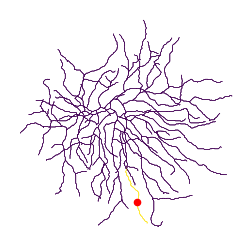

i 1
b 142


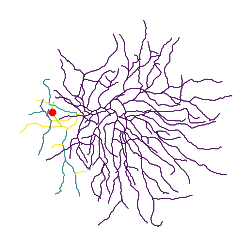

In [21]:
cmap = mpl.cm.get_cmap('viridis')

for i in range(len(inds)):
    print('i', i)
    with open(f"../results/03_results/compartemtalization_ca_{i}.pkl", "rb") as handle:
        ca = pickle.load(handle)

    calcium = ca
    calcium /= 0.015
    calcium = calcium[0]  # Remove batch dim

    with mpl.rc_context(fname="../../../.matplotlibrc"):
        fig, ax = plt.subplots(1, 1, figsize=(3.0, 2.95))
        for b in range(155):
            color = cmap(calcium[b])
            ax = cell.branch(b).vis(ax=ax, col=color, morph_plot_kwargs={"zorder": 1000, "linewidth": 0.3})

        # Visualize stimulus.
        b = stim_branches_save[i]
        print("b", b)
        c = stim_comps_save[i]
        ax = cell.branch(b).loc(c).vis(ax=ax, col="r", morph_plot_kwargs={"zorder": 1000, "s": 20.0})  # , "marker": "x", "linewidth": 1.0})

        _ = ax.spines["left"].set_visible(False)
        _ = ax.spines["bottom"].set_visible(False)
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])

        plt.show()

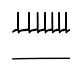

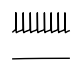

In [22]:
otherside_inds = [80, 78]

for i in range(2):
    with open(f"../results/03_results/compartemtalization_v_{i}.pkl", "rb") as handle:
        v_and_ca = pickle.load(handle)

    with mpl.rc_context(fname="../../../.matplotlibrc"):
        fig, ax = plt.subplots(2, 1, figsize=(0.8, 0.7))

        # Visualize stimulus.
        b = stim_branches_save[i]
        v_close = v_and_ca[0, b + 155]
        v_far = v_and_ca[0, otherside_inds[i] + 155]

        _ = ax[0].plot(v_close, c="k")
        _ = ax[1].plot(v_far, c="k")
        for j in range(2):
            _ = ax[j].spines["left"].set_visible(False)
            _ = ax[j].spines["bottom"].set_visible(False)
            _ = ax[j].set_xticks([])
            _ = ax[j].set_yticks([])
            _ = ax[j].set_ylim([-90, 50])
        plt.subplots_adjust(hspace=0.0)
        plt.savefig(f"../svg/panel_d{i+3}.svg", bbox_inches="tight", transparent=True)
        plt.show()

### Panel e: receptive fields

In [23]:
roi_ids = np.cumsum([0] + number_of_recordings_each_scanfield)[:-1]

with open("../results/03_results/all_images.pkl", "rb") as handle:
    all_images = pickle.load(handle)

with open("../results/03_results/all_ca_recordings.pkl", "rb") as handle:
    all_ca_recordings = pickle.load(handle)

with open("../results/03_results/all_ca_predictions.pkl", "rb") as handle:
    all_ca_predictions = pickle.load(handle)

with open("../results/03_results/all_masks.pkl", "rb") as handle:
    all_masks = pickle.load(handle)

with open("../results/03_results/roi_ids.pkl", "rb") as handle:
    roi_ids = pickle.load(handle)


In [24]:
# Compute receptive fields.
counters = np.arange(0, 147, 1)
noise_mag = 0.1
num_iter = 20
rfs_trained = compute_all_trained_rfs(counters, all_masks, all_ca_predictions, all_images, noise_mag, num_iter)

In [26]:
with open(f"../results/03_results/rfs_trained.pkl", "wb") as handle:
    pickle.dump(rfs_trained, handle)

with open(f"../results/03_results/setup.pkl", "wb") as handle:
    pickle.dump(setup, handle)

In [30]:
avg_recordings["roi_id"] = avg_recordings["roi_id"].astype(int)
rec_and_roi = avg_recordings[["rec_id", "roi_id"]].to_numpy()
rec_ids_of_all_rois = rec_and_roi[:, 0]
roi_ids_of_all_rois = rec_and_roi[:, 1]
avg_recordings = avg_recordings.reset_index()

center = np.asarray([170, 150])
pixel_size = 30
levels = [0.5]
upsample_factor = 1
output_shape = (np.array([20, 15]) * upsample_factor).astype(int)

In [31]:
cmap = plt.get_cmap("viridis")
from skimage.transform import resize
center = np.asarray([170, 150])

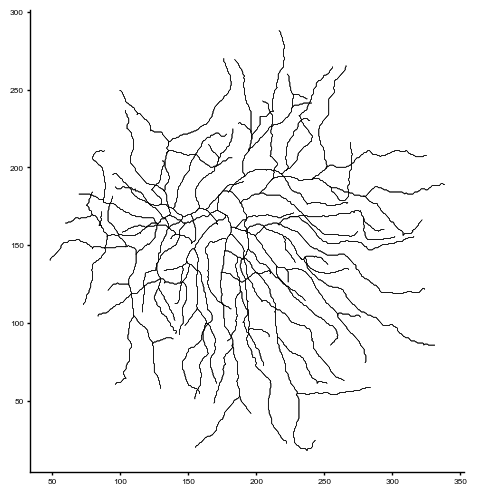

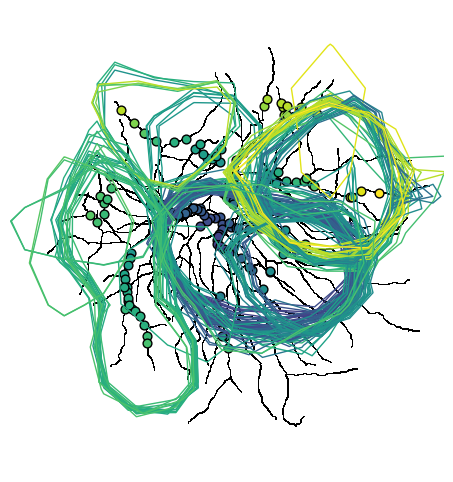

In [32]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(4 * 1.4, 4 * 1.5))

    for i, counter in enumerate(counters):
        ax = cell.vis(ax=ax, col="k", morph_plot_kwargs={"zorder": 1000, "linewidth": 0.3})

        rec_id = rec_ids_of_all_rois[counter]
        roi_id = roi_ids_of_all_rois[counter]
        rf_pred = rfs_trained[i]
        setup_rec = setup[setup["rec_id"] == rec_id]
        offset_x = setup_rec["image_center_x"].to_numpy()[0]
        offset_y = setup_rec["image_center_y"].to_numpy()[0]

        im_pos_x = (np.linspace(-7.0 * pixel_size, 7.0 * pixel_size, 15 * upsample_factor)+ offset_x)
        im_pos_y = (-np.linspace(-9.5 * pixel_size, 9.5 * pixel_size, 20 * upsample_factor) + offset_y)
        image_xs, image_ys = np.meshgrid(im_pos_x, im_pos_y)

        rec = avg_recordings.loc[counter]
        dist = np.sqrt(np.sum((center - np.asarray([rec["roi_x"].item(), rec["roi_y"].item()])) ** 2))
        col = cmap((dist + 20) / 150)

        _ = ax.scatter(
            rec["roi_x"].item(),
            rec["roi_y"].item(),
            color=col,
            s=40.0,
            edgecolors="k",
            zorder=10000,
        )

        upsampled_rf = resize(rf_pred, output_shape=output_shape, mode="constant")
        _ = ax.contour(
            image_xs,
            image_ys,
            upsampled_rf,
            levels=levels,
            colors=[col],
            linestyles="solid",
            linewidths=1.0,
            zorder=100_000,
        )

    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    _ = ax.set_xlim([center[0] - pixel_size * 5, center[0] + pixel_size * 6])
    _ = ax.set_ylim([center[1] - pixel_size * 5.5, center[1] + pixel_size * 5.5])

    plt.show()